In [1]:
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime
import numpy as np
import os, sys
import math
from matplotlib import cm
from matplotlib.patches import Circle,Wedge,Rectangle
%matplotlib inline

In [2]:
data=pd.read_excel(r"N:\Planning - New File Structure\Performance\RidershipAutomation.xlsx")
df=pd.DataFrame(data)

In [3]:
routes=pd.read_csv(r"N:\Planning - New File Structure\GIS\Data\GTFS\VRT5_10_18\routes.txt")

In [4]:
df.set_index(['Stat','Service','Route','Area','route_id'],inplace=True)

In [5]:
df.columns=pd.to_datetime(df.columns)

In [6]:
UPT_FR_18=df.loc[['UPT','FR'],datetime.date(year=2017,month=10,day=1):datetime.date(year=2018,month=9,day=1)]
UPT_FR_17=df.loc[['UPT','FR'],datetime.date(year=2016,month=10,day=1):datetime.date(year=2017,month=9,day=1)]

In [7]:
UPT_FR_17_Total=UPT_FR_17.sum(axis=0).sum()
UPT_FR_18_Total=UPT_FR_18.sum(axis=0).sum()

In [8]:
YearOverYearRidership=(UPT_FR_18_Total-UPT_FR_17_Total).round(-2)
YearOverYearRidershipPct=int(((UPT_FR_18_Total/UPT_FR_17_Total)-1)*100)
YearOverYearRidershipPct

10

In [9]:
ring_data=pd.DataFrame([UPT_FR_18_Total,UPT_FR_17_Total]).T
ring_data.columns=['2018','2017']

In [10]:
def degree_range(n): 
    start = np.linspace(-90,90,n+1, endpoint=True)[0:-1]
    end = np.linspace(-90,90,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

In [11]:
def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

In [12]:
def gauge(labels=['LOW','MEDIUM','HIGH','VERY HIGH','EXTREME'], \
          colors='jet_r', arrow=1, title='', fname=False,arrow_size=1,arrow_color='black'): 
    
    """
    some sanity checks first
    
    """
    
    N = len(labels)
    
    if arrow > N: 
        raise Exception("\n\nThe category ({}) is greated than \
        the length\nof the labels ({})".format(arrow, N))
 
    
    """
    if colors is a string, we assume it's a matplotlib colormap
    and we discretize in N discrete colors 
    """
    
    if isinstance(colors, str):
        cmap = cm.get_cmap(colors, N)
        cmap = cmap(np.arange(N))
        colors = cmap[::-1,:].tolist()
    if isinstance(colors, list): 
        if len(colors) == N:
            colors = colors[::-1]
        else: 
            raise Exception("\n\nnumber of colors {} not equal \
            to number of categories{}\n".format(len(colors), N))

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(N)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, title, horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = mid_points[abs(arrow - N)]
    
    ax.arrow(0, 0, (0.225*(math.sqrt(arrow_size))) * np.cos(np.radians(-pos)), 0.225 * np.sin(np.radians(-pos)), \
                 width=0.04*(math.sqrt(arrow_size)), head_width=0.09*(math.sqrt(arrow_size)), head_length=0.1*(math.sqrt(arrow_size)), color=arrow_color)
    
    ax.add_patch(Circle((0, 0), radius=0.02*(math.sqrt(arrow_size)), color=arrow_color))
    #ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)

In [13]:
by_route18=df.loc[:,datetime.date(year=2017,month=10,day=1):datetime.date(year=2018,month=9,day=1)].groupby('Route').sum()
by_route17=df.loc[:,datetime.date(year=2016,month=10,day=1):datetime.date(year=2017,month=9,day=1)].groupby('Route').sum()

by_route18=by_route18.sum(axis=1)
by_route17=by_route17.sum(axis=1)

ring_data_routes=pd.DataFrame([by_route18,by_route17]).T
ring_data_routes.columns=['2018','2017']

In [14]:
ring_data_routes['PercentChange']=ring_data_routes['2018']/ring_data_routes['2017']
ring_data_routes['Change']=ring_data_routes['2018']-ring_data_routes['2017']

In [15]:
ring_data_routes['Arrow']=pd.qcut(ring_data_routes['PercentChange'],6,labels=[1,2,3,4,5,6])
ring_data_routes['Size']=pd.qcut(ring_data_routes['Change'],6,labels=[1,2,3,4,5,6])
ring_data_routes['Arrow']=ring_data_routes.Arrow.astype(float)
ring_data_routes['Size']=ring_data_routes.Size.astype(int)

In [16]:
positive=ring_data_routes[ring_data_routes.Change>0]
positive['Arrow']=pd.qcut(positive['PercentChange'],3,labels=[20,40,60])
positive['Size']=pd.qcut(positive['Change'],3,[.25,.5,.75])
negative=ring_data_routes[ring_data_routes.Change<0]
negative['Arrow']=pd.qcut(negative['PercentChange'],3,labels=[-60,-40,-20])
negative['Size']=pd.qcut(negative['Change'],3,labels=[.25,.5,.75])
negative
ring_data_routes=pd.concat([positive,negative])

C:\Users\bparker\AppData\Local\conda\conda\envs\mappingPy3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\bparker\AppData\Local\conda\conda\envs\mappingPy3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\bparker\AppData\Local\conda\conda\envs\mappingPy3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [17]:
arrow=ring_data_routes.iloc[:,4]
size=ring_data_routes.iloc[:,5]
needs=pd.DataFrame([arrow,size]).T

In [18]:
needs.Arrow=needs.Arrow.map(float)
needs.Size=needs.Size.map(float)
route_colors=['#ffcd00','#fbb161','#fbb161','#ba0c2f','#b6bd00','#b58150','#934d11','#00a9ce','#009639','#685bc7','#51284f','#009639','#ff8200','#05c3de','#aa8066','#ff5c39','#486b4c','#97d700','#bb29bb','#008c95','#8b0e04','#f8971d','#63619a','black','black','#40b170','#0072ce','#e93cac','#e93cac','#009ca6','#009ca6','#001489','#001489','#01286b','#00917b','#3a3b42','#CE5504']
needs['color']=route_colors

In [19]:
needs.reset_index(inplace=True)


In [20]:
#for index, row in needs.iterrows():
 #   gauge(labels=['','','','','',''],colors=['#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff'],arrow=row['Arrow'],arrow_size=row['Size'],arrow_color=row['color'])

In [21]:
def arrowdrawer(df,figsize,fname=False):
    fig=plt.figure(figsize=figsize)
    for i, (name,row) in enumerate(df.iterrows()):
        ax=plt.subplot(10,4,i+1)
        ax.set_title(row['Route'])
        x0,y0=1,1
        radius=row['Size']
        angle=row['Arrow']
        angle_rad = angle * math.pi / 180  # degrees to radians
        head_length=.025*(10*row['Size'])
        ax.arrow(x0,y0,
                (radius)*math.cos(angle_rad),
                (radius)*math.sin(angle_rad),
                head_width=head_length,head_length=head_length,color=row['color'],width=head_length/2)
        ax.add_patch(Circle((x0,y0), radius=head_length/4,color=row['color']))
        plt.axis([0,2,0,2])
        plt.axis('off')
    


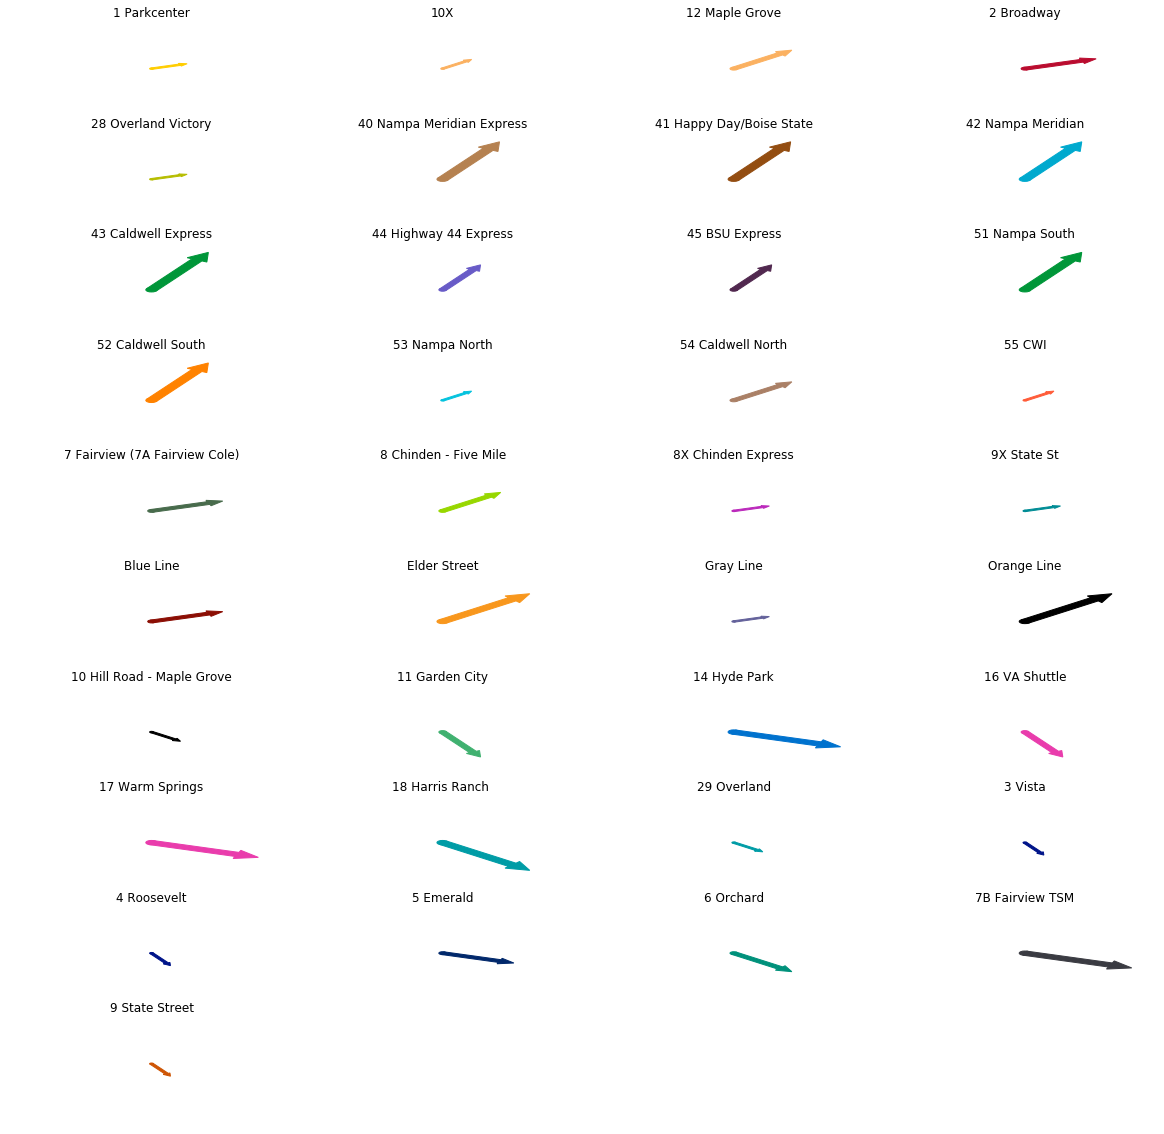

In [22]:
arrowdrawer(needs,figsize=(20,20))